# Maxgradstep effects

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys, time, os
from tqdm import tqdm
import pandas as pd
%matplotlib inline

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# https://matplotlib.org/examples/color/named_colors.html

from utils import timed_func, combine_df

In [4]:
def find_df_by_lang(lang):
    archive = "../src/archive"
    fnames = [
        "20200508_en_fr_es_maxgradstep_1500",
        "20200508_en_fr_es_maxgradstep_3000",
        "20200508_en_fr_es_maxgradstep_6000",
        "20200512_en_fr_es_maxgradstep_12000",
        "20200512_en_fr_es_maxgradstep_24000",
        "20200516_en_fr_es_maxgradstep_48000",
        "20200516_en_fr_es_maxgradstep_96000",
        "20200519_en_fr_es_maxgradstep_additional"
    ]
    dfs = []
    for fn in fnames:
        df = combine_df(os.path.join(archive, fn))
        dfs.append(df)
    long_df = pd.concat(dfs)
    return long_df[long_df.lang==lang]

df = find_df_by_lang("en")
print(df.shape)
df.head()

(6799, 15)


,lm,lang,task,layer,dim,batch_size,init_lr*1e6,lr_anneal,max_grad_step,train_steps,seed,devloss,testloss,acc,weight_decay
0,bertmulti,en,probe,0.0,10.0,32.0,100.0,0.5,1500.0,1500.0,73.0,inf,1.404745,66.479663,NaN
1,bertmulti,en,probe,0.0,10.0,32.0,100.0,0.5,1500.0,1500.0,421.0,inf,1.437746,64.983637,NaN
2,bertmulti,en,probe,0.0,10.0,32.0,100.0,0.5,1500.0,1500.0,9973.0,inf,1.365502,64.341876,NaN
3,bertmulti,en,probe,0.0,10.0,32.0,100.0,0.5,1500.0,1500.0,361091.0,inf,1.319181,63.088104,NaN
4,bertmulti,en,ctarget,0.0,10.0,32.0,100.0,0.5,1500.0,1500.0,73.0,inf,2.833308,5.937354,NaN


In [5]:
def analyze_results(df):
    """
    For each layer-dim configuration, for each maxgradstep, what testloss/acc can the best LR give?
    """
    df_with_mean = df.groupby(['lang', "task", 'layer', 'dim', "init_lr*1e6", "max_grad_step"]).mean()
    res = {}
    for idx, row in df_with_mean.iterrows():
        config = tuple([idx[1], idx[2], idx[3], idx[5]])
        if config not in res or row.testloss < res[config].testloss:
            res[config] = row
            
    export = {
        "layer": [], "dim": [], "max_grad_step": [], "acc": [], "ent": [], "rmt_acc": [], "rmt_ent": [], "rmr_acc": [], "rmr_ent": []
    }
    for config in res:
        task, layer, dim, maxstep = config
        row = res[config]
        if task == "probe":
            tconfig = tuple(["ctarget", layer, dim, maxstep])
            rconfig = tuple(["crep", layer, dim, maxstep])
            if (tconfig in res) and (rconfig in res):
                trow = res[tconfig]
                rrow = res[rconfig]
                
                rmt_acc = row.acc - trow.acc
                rmr_acc = row.acc - rrow.acc
                rmt_ent = -row.testloss + trow.testloss
                rmr_ent = -row.testloss + rrow.testloss
                
                export["layer"].append(layer)
                export["dim"].append(dim)
                export["max_grad_step"].append(maxstep)
                export["acc"].append(row.acc)
                export["ent"].append(row.testloss)
                export["rmt_acc"].append(rmt_acc)
                export["rmt_ent"].append(rmt_ent)
                export["rmr_acc"].append(rmr_acc)
                export["rmr_ent"].append(rmr_ent)
    return pd.DataFrame(export).sort_values(["layer", "dim", "max_grad_step"])
            
res_df = analyze_results(find_df_by_lang("en"))
print(res_df.shape)
res_df.head()

(89, 9)


,layer,dim,max_grad_step,acc,ent,rmt_acc,rmt_ent,rmr_acc,rmr_ent
0,0.0,10.0,1500.0,63.876493,1.333966,57.942326,1.499240,52.184538,1.460767
1,0.0,10.0,3000.0,67.930001,1.228990,62.019210,1.604235,55.828977,1.560839
2,0.0,10.0,6000.0,69.296400,1.123910,63.362234,1.709295,56.568490,1.656457
3,0.0,10.0,12000.0,69.177398,1.129307,63.244294,1.703898,56.425050,1.650554
4,0.0,10.0,24000.0,71.953759,1.079270,66.022780,1.753926,62.161588,1.662223


In [11]:
def make_acc_plots(res_df, lang):
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(15,6))
    
    cnt = 0
    for j, ldconfig in res_df[["layer", "dim"]].drop_duplicates().iterrows():
        layer = int(ldconfig.layer)
        dim = int(ldconfig.dim)
        if (layer, dim) in [(1, 60), (1, 100), (1, 160), (2, 60), (2, 100)]:
            continue
        df_tmp = res_df[(res_df.layer==layer) & (res_df.dim==dim)]
        
        ax = axes[cnt // 5][cnt % 5]
        cnt += 1
        ax.title.set_text("layer={} dim={}".format(layer, dim))
        
        c1 = colors["blue"]
        ax.plot(df_tmp.max_grad_step, df_tmp.acc, c=c1, label="Accuracy")
        ax.scatter(df_tmp.max_grad_step, df_tmp.acc, c=c1, s=10)
        c2 = colors["skyblue"]
        ax.plot(df_tmp.max_grad_step, df_tmp.rmt_acc, c=c2, label="t_acc")
        ax.scatter(df_tmp.max_grad_step, df_tmp.rmt_acc, c=c2, s=10)
        c3 = colors["cyan"]
        ax.plot(df_tmp.max_grad_step, df_tmp.rmr_acc, c=c3, label="f_acc")
        ax.scatter(df_tmp.max_grad_step, df_tmp.rmr_acc, c=c3, s=10)
        
        if cnt == 1:
            ax.legend()
        if cnt > 5:
            ax.set_xlabel("Max gradient steps")
        if cnt % 5 == 1:
            ax.set_ylabel("Accuracy")
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.97]) 
    plt.suptitle("Accuracy vs t_acc r_acc, {}".format(lang), fontsize=15)
    plt.savefig("0517_maxgradstep/maxgradstep_acc_{}.png".format(lang), dpi=300)
    plt.show()


In [7]:
def make_ent_plots(res_df, lang):
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(15,6))
    
    cnt = 0
    for j, ldconfig in res_df[["layer", "dim"]].drop_duplicates().iterrows():
        layer = int(ldconfig.layer)
        dim = int(ldconfig.dim)
        if (layer, dim) in [(1, 60), (1, 100), (1, 160), (2, 60), (2, 100)]:
            continue
        df_tmp = res_df[(res_df.layer==layer) & (res_df.dim==dim)]
        
        ax = axes[cnt // 5][cnt % 5]
        cnt += 1
        ax.title.set_text("layer={} dim={}".format(layer, dim))
        
        c1 = colors["green"]
        ax.plot(df_tmp.max_grad_step, df_tmp.ent, c=c1, label="Loss")
        ax.scatter(df_tmp.max_grad_step, df_tmp.ent, c=c1, s=10)
        c2 = colors["lightgreen"]
        ax.plot(df_tmp.max_grad_step, df_tmp.rmt_ent, c=c2, label="t_ent")
        ax.scatter(df_tmp.max_grad_step, df_tmp.rmt_ent, c=c2, s=10)
        c3 = colors["lime"]
        ax.plot(df_tmp.max_grad_step, df_tmp.rmr_ent, c=c3, label="f_ent")
        ax.scatter(df_tmp.max_grad_step, df_tmp.rmr_ent, c=c3, s=10)
        
        if cnt == 1:
            ax.legend()
        if cnt > 5:
            ax.set_xlabel("Max gradient steps")
        if cnt % 5 == 1:
            ax.set_ylabel("Cross Entropy")
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.97]) 
    plt.suptitle("Loss vs t_ent and r_ent, {}".format(lang), fontsize=15)
    plt.savefig("0517_maxgradstep/maxgradstep_ent_{}.png".format(lang), dpi=300)
    plt.show()

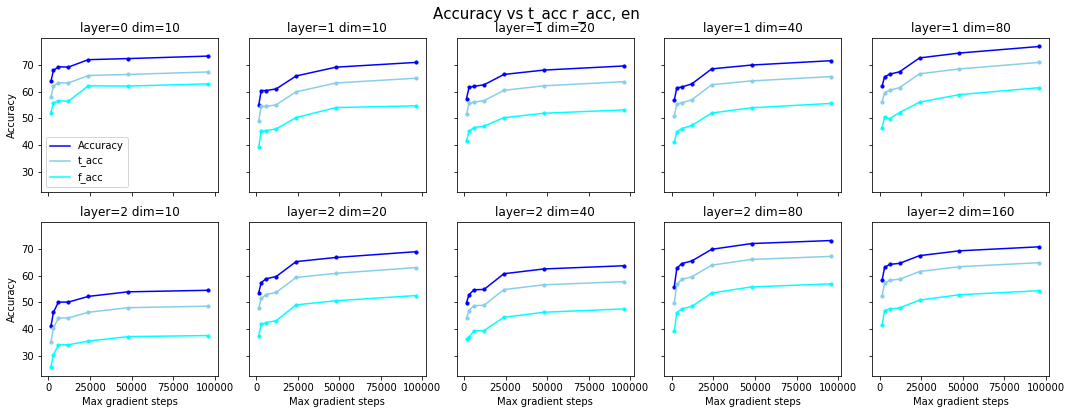

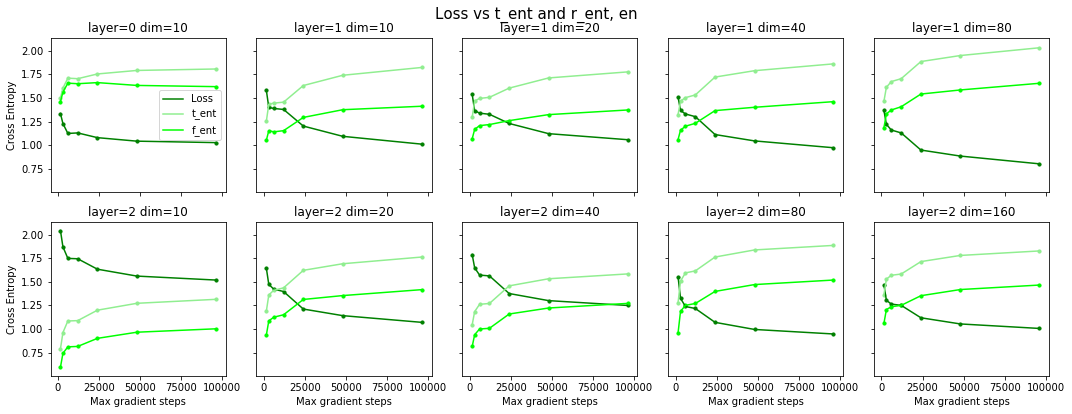

In [12]:
res_df = analyze_results(find_df_by_lang("en"))
make_acc_plots(res_df, "en")
make_ent_plots(res_df, "en")

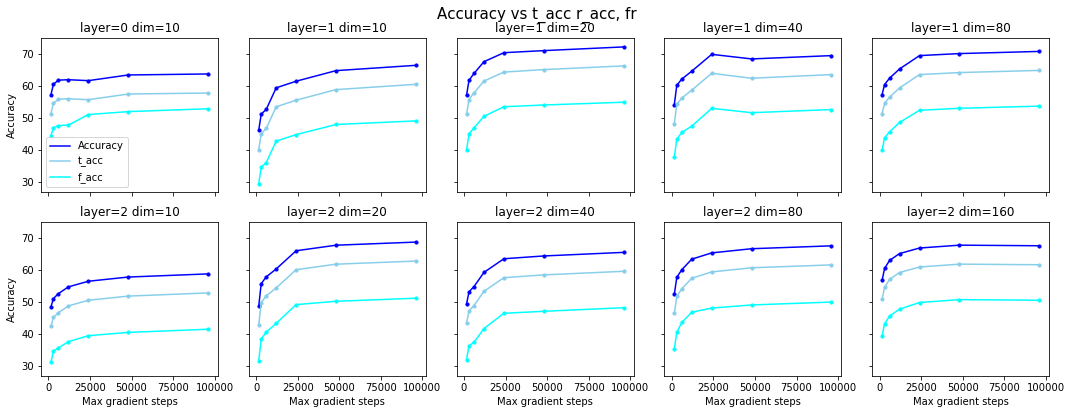

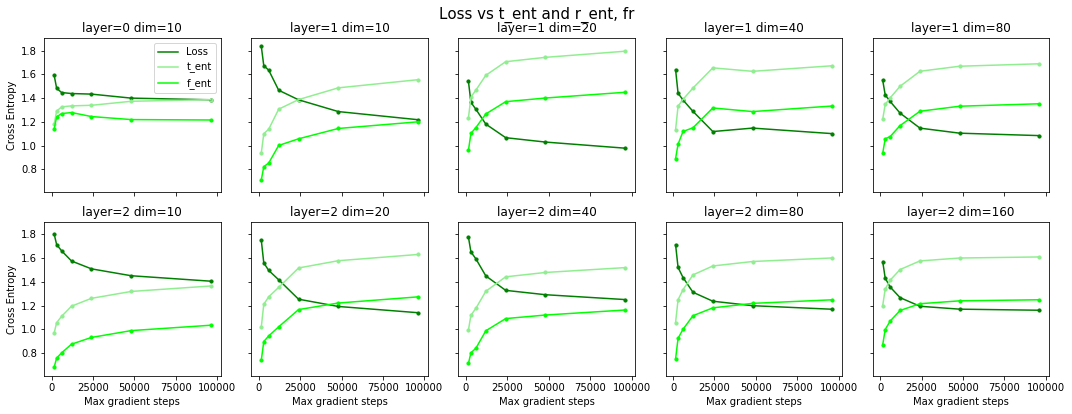

In [13]:
res_df = analyze_results(find_df_by_lang("fr"))
make_acc_plots(res_df, "fr")
make_ent_plots(res_df, "fr")

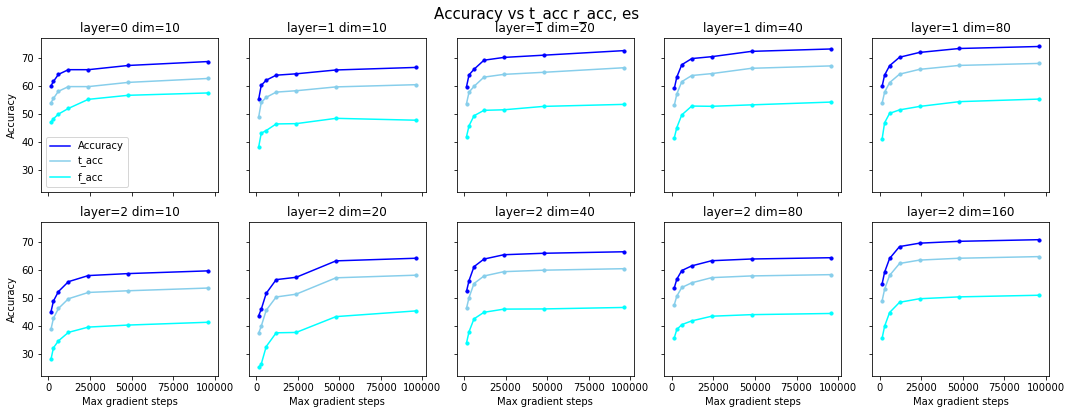

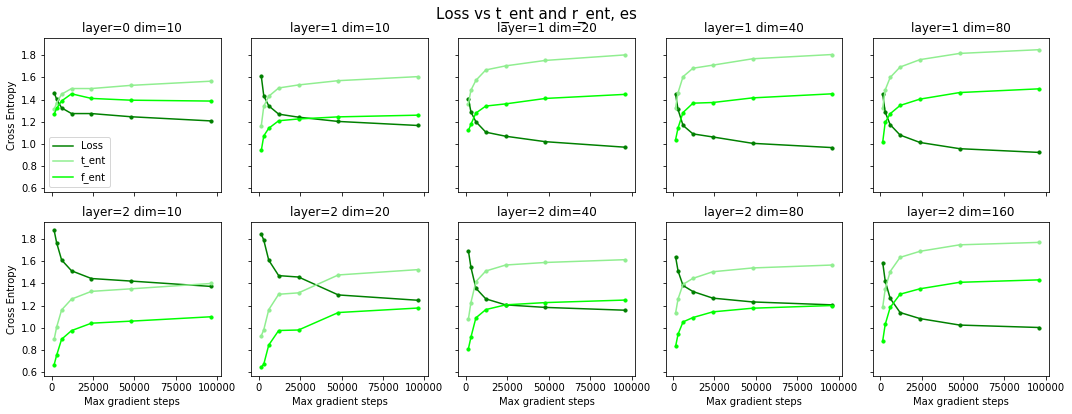

In [14]:
res_df = analyze_results(find_df_by_lang("es"))
make_acc_plots(res_df, "es")
make_ent_plots(res_df, "es")